# Bike Share System Usage
CMSC320 Final Project
By: Jessica Lee, Kelley Li


## Contents
1. Introduction
2. Libraries Used
3. Dataset
4. Importing Data
5. Data Cleaning
6. Data Exploration and Preliminary Data Analysis
7. Hypothesis Testing
8. Machine Learning
9. Conclusion
10. References

## Introduction

Bike share programs are a type of shared public transporatation system that is considered to be eco-friendly and sustainable. Typically these systems work by allowing people to rent bikes at a station, travel to their destination, and return the bike to another station. Such bike programs are frequently implemented in more densly populated areas such as cities, and have been relatively successful. Majority of revenue is from bike users and the the length of time they borrow a bike. Thus, from a business model standpoint, it is important to know who the users are, and common patterns that is seen among users. Knowing this information can allow us to see what business strategies can be used to optimize the conditions in which people use bike share programs and potentially incentivize people to use these more.

In this tutorial, our goal is to create a walkthrough of the data science lifecycle and show how data science tools and techniques can be used to analyze for patterns within data, and make inferences from the data to make predictions.


## Libraries Used  
In this tutorial, we used the following libraries:
* sqlite3
* pandas
* numpy
* matplotlib
* folium
* json
* seaborn
* scipy

Please also note we are also using Python 3

In [39]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json 
import seaborn as sns
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Dataset
The dataset used was obtained from Kaggle and is a dataset on a bike share program in San Francisco bay area. It contains 2 years of anonymized bike trip data from August 2013 to August 2015. In total, there are 4 tables: station, status, trip, and weather.

Station has a total of 70 rows and 7 columns. This consists of data that represent stations where users can borrow and return bikes. Status has a total of 71,984,434 rows and 4 columns. This consists of minute by minute data about the number of bikes and docks avaliable at each station. Due to the sheer size of this table, we chose to not include any data contained in this table due to limits in computing power. Trip has a total of 669,959 rows and 11 columns. This consists of individual bike trip data. Weather has a total of 3665 rows and 24 columns. It consists of data about the weather on a particular day for specific zipcodes.

More information on the origin of the dataset can be found here: [SF Bay Area Bike Share Data](https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share)

## Importing Data
After obtaining our data from Kaggle, our next step is to import our data into pandas dataframes. Our data from Kaggle includes a zip file that we unzipped locally, which contains a sqlite version of the data and csv version of the data. Below, we decided to import our data via the sqlite file, however, we can also just read the csv files with `<dataframe> = pd.read_csv(<file path>)` for all csv files. 

We first verify that the sqlite file contains all tables. We obtain a list of table names, which reveal the tables to be station, status, trip, and weather as expected.

In [40]:
# create connection to sqlite file
con = sqlite3.connect("database.sqlite")

# get tables
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor = con.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[('station',), ('status',), ('trip',), ('weather',)]


To extract an entire table, we use SQL statements to pull all rows from each table, and insert those into a dataframe. Note that for this tutorial we will only be using 3 of the 4 tables for reasons mentioned in the previously in which one table has too much data that our computing environment can handle. We can then output the columns as well as a few rows of each dataframe to get a general idea what data is available in each extracted table.

In [41]:
# Extract data from sqlite file with SQL queries
station = pd.read_sql_query("SELECT * from station", con)
trip = pd.read_sql_query("SELECT * from trip", con)
weather = pd.read_sql_query("SELECT * from weather", con)

# if you would like to try out reading from csv files, you can try uncommenting the code segment below!
#station = pd.read_csv("station.csv")
#trip = pd.read_csv("trip.csv")
#weather = pd.read_csv("weather.csv")

In [4]:
# Output station table info
print(station.dtypes)
station.head()

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object


,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [5]:
# Output trip table info
print(trip.dtypes)
trip.head()

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4069,174,8/29/2013 9:08,2nd at South Park,64,8/29/2013 9:11,2nd at South Park,64,288,Subscriber,94114
1,4073,1067,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:42,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703
2,4074,1131,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115
3,4075,1117,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122
4,4076,1118,8/29/2013 9:25,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597


In [6]:
# Output weather table info
print(weather.dtypes)
weather.head()

date                              object
max_temperature_f                 object
mean_temperature_f                object
min_temperature_f                 object
max_dew_point_f                   object
mean_dew_point_f                  object
min_dew_point_f                   object
max_humidity                      object
mean_humidity                     object
min_humidity                      object
max_sea_level_pressure_inches     object
mean_sea_level_pressure_inches    object
min_sea_level_pressure_inches     object
max_visibility_miles              object
mean_visibility_miles             object
min_visibility_miles              object
max_wind_Speed_mph                object
mean_wind_speed_mph               object
max_gust_speed_mph                object
precipitation_inches              object
cloud_cover                       object
events                            object
wind_dir_degrees                  object
zip_code                           int64
dtype: object


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74,68,61,61,58,56,93,75,57,...,10,10,23,11,28,0,4,,286,94107
1,8/30/2013,78,69,60,61,58,56,90,70,50,...,10,7,29,13,35,0,2,,291,94107
2,8/31/2013,71,64,57,57,56,54,93,75,57,...,10,10,26,15,31,0,4,,284,94107
3,9/1/2013,74,66,58,60,56,53,87,68,49,...,10,10,25,13,29,0,4,,284,94107
4,9/2/2013,75,69,62,61,60,58,93,77,61,...,10,6,23,12,30,0,6,,277,94107


## Data Cleaning

After importing the data, our next step is to clean it. From the above, we see some of the data types for the columns are not ideal and would want to transform them to be something easier to use before performing any analysis. For example, date related data can be converted to datetime objects and numerical values can be converted to a numerical form instead of string data. Note that the data lifecycle is a continuous cycle, thus what we performed in this section is just preliminary data cleaning, and we will continue to perfrom cleaning as we discover more about the data in later sections as needed.

We also take this opportunity to preprocess our data by creating some of our own columns based on existing data to make our analysis later easier. We do this by "binning" which is introducing a new categorical variable that can possibly provide new information. 

In [43]:
# Clean for missing data, remove any rows with missing data
station = station.dropna()
trip = trip.dropna()

# Convert weather data to numeric values
weather = weather.apply(pd.to_numeric, errors='ignore')
weather['precipitation_inches'] = pd.to_numeric(weather['precipitation_inches'], errors='coerce')

# Convert dates from string to datetime objects
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
weather['date'] = pd.to_datetime(weather['date'])
trip["date"] = pd.to_datetime(trip["start_date"]).dt.date

# Add a column for start date without time
trip["date"] = trip['start_date'].apply(lambda x: x.date())
trip['date'] = pd.to_datetime(trip['date'])

# Binning by month using the start date
trip['month'] = trip['start_date'].apply(lambda x: x.month)

## Data Exploration and Preliminary Data Analysis

In this part, our goal is to explore our data and get a better understanding of the different variables and some of their relationships. We can focus on variables that we are potentially interested and determine if there are any general trends through visualizations and statistics.

To get a better understanding of the bike program, we can first start by mapping out the location of all stations.

In [44]:
# Create a map and center it
map_osm = folium.Map(location=[37.580000, -122.28000], zoom_start=10)

# Mark all the stations on map
for index, station_info in station.iterrows():
    tooltip_text = station_info['name'] + "\n"
    folium.Marker(location=[station_info["lat"], station_info["long"]], tooltip=tooltip_text).add_to(map_osm)
    
map_osm

From the map output, we can also see that the bike share stations are not evenly distributed geographically. It appears there are 5 clusters centered at: San Francisco, San Jose, Redwood City, Mountain View, and Palo Alto. We can hover above each marker to obtain the name of the station indicated by the marker.

Next, we can also take a look at the trip data. We first output some summary stats to get a general idea what numerical data exists.

In [9]:
trip.describe()

,id,duration,start_station_id,end_station_id,bike_id,month
count,669959.000000,6.699590e+05,669959.000000,669959.000000,669959.000000,669959.000000
mean,460382.009899,1.107950e+03,57.851876,57.837438,427.587620,6.476844
std,264584.458487,2.225544e+04,17.112474,17.200142,153.450988,3.276798
min,4069.000000,6.000000e+01,2.000000,2.000000,9.000000,1.000000
25%,231082.500000,3.440000e+02,50.000000,50.000000,334.000000,4.000000
50%,459274.000000,5.170000e+02,62.000000,62.000000,440.000000,7.000000
75%,692601.000000,7.550000e+02,70.000000,70.000000,546.000000,9.000000
max,913460.000000,1.727040e+07,84.000000,84.000000,878.000000,12.000000


In this case, the summary statistics for month and ID related columns do not mean much since these are technically categorical variables that happen to be represented with number characters. However, duration appears to be interesting where the mean is approximately 1108. With such a large value, it leads to the question: what are the units? It does not appear to be in minutes or units of anything larger. Thus we can temporarily assume it is seconds and attempt to convert into minutes, and see if it gives reasonable results.

In [10]:
trip['duration'] = trip['duration'].apply(lambda x: x / 60)
trip.describe()

,id,duration,start_station_id,end_station_id,bike_id,month
count,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000
mean,460382.009899,18.465831,57.851876,57.837438,427.587620,6.476844
std,264584.458487,370.923950,17.112474,17.200142,153.450988,3.276798
min,4069.000000,1.000000,2.000000,2.000000,9.000000,1.000000
25%,231082.500000,5.733333,50.000000,50.000000,334.000000,4.000000
50%,459274.000000,8.616667,62.000000,62.000000,440.000000,7.000000
75%,692601.000000,12.583333,70.000000,70.000000,546.000000,9.000000
max,913460.000000,287840.000000,84.000000,84.000000,878.000000,12.000000


From the new mean of the duration, it appears our guess was correct that the original units was in seconds since it appears reasonable the duration of a bike trip can be around 17 minutes. The max being 287,840 minutes imply there is at least one outlier. With 75% of our bike trip duration data to be around 12.5 minutes or less, yet our mean is greater than 12.5 means our data is very skewed. Thus we can attempt to plot the distribution of the biking times to be at most 1 hours to better understand duration distribution shape with less influence from the outliers.

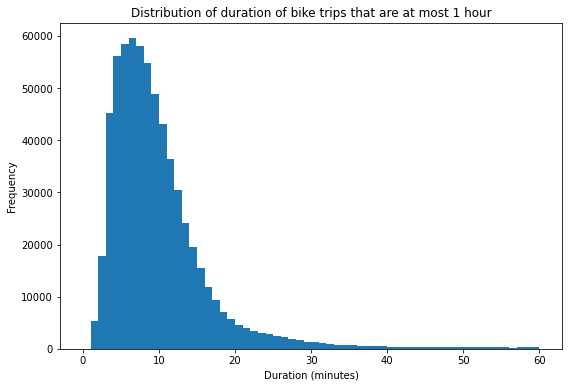

In [11]:
# histogram of the biking time duration for trips of length 1 hour
# Label points and change plot size
fig, ax = plt.subplots(figsize = (9, 6))
plt.hist(trip['duration'], bins = 60, range=[0, 1 * 60])

# Graph labels and titles
plt.title('Distribution of duration of bike trips that are at most 1 hour')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

As expected, our histogram does reveal that duration of bike trip is skewed, and has a relatively long right tail. 

The next thing we consider is the frequency of the bike trips. Is the number of bike trips a seasonal pattern?
To do this, we can use the month bins we created earlier to construct another visualization that allows us to compare the number of bike trips per month.

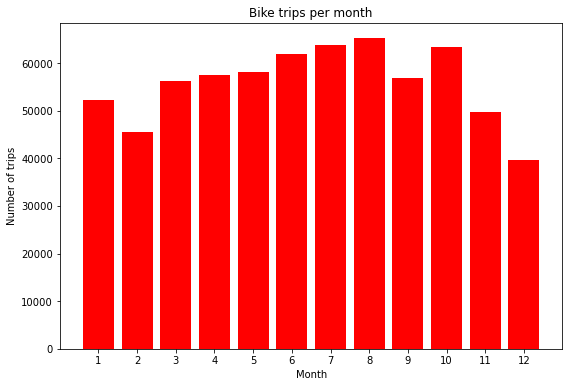

In [12]:
# number of bike trips per month
# Label points and change plot size
fig, ax = plt.subplots(figsize = (9, 6))
plt.bar(range(1, 13), np.bincount(trip['month'], minlength=13)[1:], color='red')

# Graph labels and titles
plt.title('Bike trips per month')
plt.xlabel('Month')
plt.ylabel('Number of trips')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.show()


We observe that December seems to be the month with the least bike trips and August is the month that has the most bike trips out of all other months. There seems to be a general trend where spring and summer months have more bike trips than the fall and winter months.

Thus does months also have any relationship with bike trip duration? We can visualize this with a series of box plots to see if there is.

Note for the boxplot graphed, the whiskers by default "extend no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval" according to doucmentation on the boxplot function found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html).

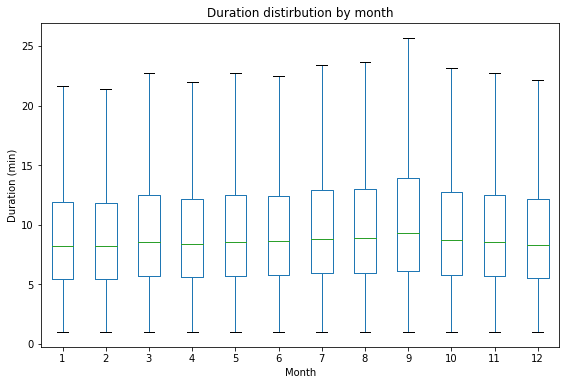

In [13]:
# Show distribution of bike duration per month via box plots

ax = trip[['month', 'duration']].boxplot(by='month', grid=False, showfliers=False, figsize=(9, 6), return_type='axes')
plt.title("Duration distirbution by month")
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Duration (min)')
plt.show()

Plotting it out, it does not seem like there are any interesting trends here. The biking duration accross all months looks about the same. The median duration of bike trips are indicated by the gren line in box are approximately the same for all months.

Before moving on to explore another table, we can consider other trends not involving time. Who are the riders for the bike trip?

In [60]:
trip['subscription_type'].value_counts()
566746/(566746+103213)

0.8459413187971204

Most of the userbase are subscribers, making up 84.59% of the total.

Next, we can explore the weather table a bit. One thing we do know from the dataset description is that we only have weather data for certain zipcodes. So what does that mean? We can start by printing out the possible values for zipcodes.

In [15]:
weather['zip_code'].value_counts()

94107    733
94063    733
94301    733
94041    733
95113    733
Name: zip_code, dtype: int64

Interestingly, we only have 5 zipcodes. We notice that zipcode 94063 and 94031 seem to have missing data since its occurances appear to be significantly different. Does this align with the zipcodes in the trip data?

In [16]:
trip['zip_code'].value_counts()

94107    78704
94105    42672
94133    31359
94103    26673
94111    21409
         ...  
44145        1
60131        1
3300         1
8033         1
9069         1
Name: zip_code, Length: 7440, dtype: int64

We notice that there is significantly more unique zipcodes in the trip data, thus we need to also bin trip by the closest zipcode. We can try to first bin this visually by creating another map that highlights where the zip code areas are. we notice that there are 5 zipcodes, and earlier we observed there are 5 clusters for station. Let us try to graph each station cluster individually and determine if these observations are related.

We first start by importing a file that can visually  represent zipcode regions on a map. This file is a geojson file, and was obtained from the San Francisco government website and contains zipcode boundaries for the Bay Area. The source link can be found [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-ZIP-Codes/u5j3-svi6)

In [17]:
# load GeoJson

zipcode_map_data= 0

with open('Bay Area ZIP Codes.geojson', 'r') as jsonFile:
    zipcode_map_data = json.load(jsonFile)


After loading in the zipcode boundary data, we can filter it for the zipcodes we are interested in.

In [18]:
# create a list of zipcodes in weather 
zip_list = ['94041', '95113', '94107', '94063', '94301']

# extract zip boundaries for the zipcodes we have
new_zip_map_data = []
for i in range(len(zipcode_map_data['features'])):
    if zipcode_map_data['features'][i]['properties']['zip'] in zip_list:
        new_zip_map_data.append(zipcode_map_data['features'][i])

# create new JSON
zipcode_map_data2 = dict.fromkeys(['type', 'features'])
zipcode_map_data2['type'] = 'FeatureCollection'
zipcode_map_data2['features'] = new_zip_map_data
      

In [19]:
# function mark all the stations per region
def add_marker_for_region(region):
    for index, station_info in station.iterrows():
        if station_info['city'] == region:
            tooltip_text = station_info['name'] + "\n"
            folium.Marker(location=[station_info["lat"], station_info["long"]], tooltip=tooltip_text).add_to(map_osm)   
    
# Map San Francisco 
map_osm = folium.Map(location=[37.7749, -122.4194], zoom_start=13)
add_marker_for_region('San Francisco')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

/Users/Licykk/opt/anaconda3/lib/python3.9/site-packages/folium/folium.py:407: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [20]:
# Map San Jose
map_osm = folium.Map(location=[37.3387, -121.8853], zoom_start=13)
add_marker_for_region('San Jose')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

In [21]:
# Map Redwood City
map_osm = folium.Map(location=[37.4848, -122.2281], zoom_start=13)
add_marker_for_region('Redwood City')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

In [22]:
# Map Mountain View
map_osm = folium.Map(location=[37.3861, -122.0839], zoom_start=13)
add_marker_for_region('Mountain View')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

In [23]:
# Map Palo Alto
map_osm = folium.Map(location=[37.4419, -122.1430], zoom_start=13)
add_marker_for_region('Palo Alto')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

From the 5 maps of the different station clusters above, it does appear to align with our theory that the weather data aligns with a group of stations by the cluster they are in. We can add this newly discovered information to our dataframes by binning technique again.

We start by first mapping the zipcodes to the corresponding city regions in a dictionary. A quick Google search on Google allows us to determine what zipcodes correspond to what city region:  
* Mountain View : 94041
* San Jose : 95113
* San Francisco : 94107
* Redwood City : 94063
* Palo Alto : 94301

In [24]:
# associate the zipcodes zip_list = ['94041', '95113', '94107', '94063', '94301'] to one of the 5 cities: 
# San Francisco, San Jose, Redwood City, Mountain View, and Palo Alto

city_dict1 = {'94041':'Mountain View', '95113':'San Jose', '94107':'San Francisco', '94063':'Redwood City', '94301':'Palo Alto'}
city_dict2 = {'Mountain View':'94041', 'San Jose':'95113', 'San Francisco':'94107', 'Redwood City':'94063', 'Palo Alto':'94301'}

# we add the city mapping to a zipcode
station['zipcode'] = station['city'].apply(lambda x: city_dict2[x])

# we add zipcode to city mapping in weather
weather['city'] = weather['zip_code'].apply(lambda x: city_dict1[str(x)])


In [25]:
# we assign a bin for each trip based on start location station

station_tmp =  station[['id', 'name', 'city', 'zipcode', 'dock_count']]

# we can use the bins as keys to merge all our data into one dataframe!
# merge station info into trip data
trip_tmp = pd.merge(left=trip,right=station_tmp, how = "inner", \
                    left_on = ['start_station_id', 'start_station_name'], right_on = ['id', 'name'])
trip_tmp.rename(columns={'id_x': 'trip_id', 'zipcode' : 'city_zip'}, inplace=True)

# remove duplicate column from merge key
trip_tmp = trip_tmp.drop('id_y', axis=1)
trip_tmp = trip_tmp.drop('name', axis=1)

# merge weather info into trip data
# convert weather zipcode to string to ensure data type alignment
weather['zip_code'] = weather['zip_code'].apply(lambda x: str(x))

trip_tmp = pd.merge(left=trip_tmp, right=weather, how = "inner", left_on=['date', 'city', 'city_zip'],\
                   right_on = ['date', 'city', 'zip_code'])
trip_tmp.rename(columns={'zip_code_x': 'trip_zip_code'}, inplace=True)
trip_tmp = trip_tmp.drop('zip_code_y', axis=1)

trip_all_data = trip_tmp.copy(deep=True)

We're also interested in seeing whether weather conditions influence how many riders make a trip on that day. For that, we need to count the number of trips that hapepn on any particular date.

In [26]:
# Get trips per day

trips_by_date = trip.groupby(["date"])
trips = trips_by_date.size()

From there, we also need the weather for the day. There is a bit of a snag, since the weather database is seperated by zip code, with unique data for each zip code for each day. We get around this by getting the average of all the zip codes for each day.

In [67]:
# Group data
weather_by_date = weather.groupby("date")

weather_by_date = weather_by_date.mean()
weather_by_date["trips"] = trips
# weather_by_date = weather_by_date.drop("zip_code", axis=1)
weather_by_date["day"] = weather_by_date.index
weather_by_date["day"] = pd.to_datetime(weather_by_date["day"])
weather_by_date["day"] = weather_by_date["day"].dt.dayofweek
weather_by_date.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code,trips,day
date,,,,,,,,,,,,,,,,,,,,,
2013-08-29,78.6,70.4,62.8,62.6,60.0,58.0,88.8,73.2,53.0,30.064,...,10.0,17.8,7.4,21.6,0.0,4.2,325.8,94325.0,748,3
2013-08-30,84.6,73.0,62.4,63.4,59.8,55.8,90.8,68.8,42.4,30.054,...,9.4,19.4,5.6,23.0,0.0,2.0,181.8,94325.0,714,4
2013-08-31,76.4,68.0,59.8,59.6,57.2,54.4,88.2,70.8,51.6,29.994,...,10.0,18.4,7.4,24.5,0.0,1.0,324.6,94325.0,640,5
2013-09-01,79.2,70.0,61.0,61.2,57.2,53.6,83.4,66.8,44.4,29.962,...,10.0,18.6,7.2,21.8,0.0,2.2,318.8,94325.0,706,6
2013-09-02,77.4,70.8,64.6,62.8,60.8,58.4,85.8,74.0,58.8,29.972,...,9.2,18.2,7.4,22.6,0.0,5.0,311.4,94325.0,661,0


We can also take a look and see whether any of the weather data correlates with the number of trips.

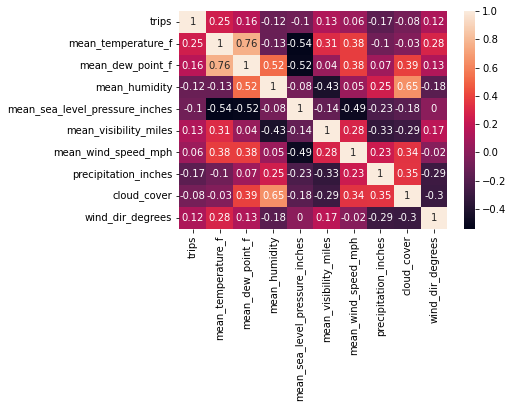

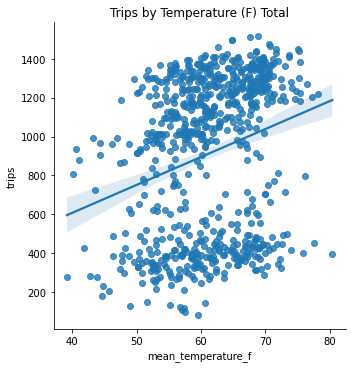

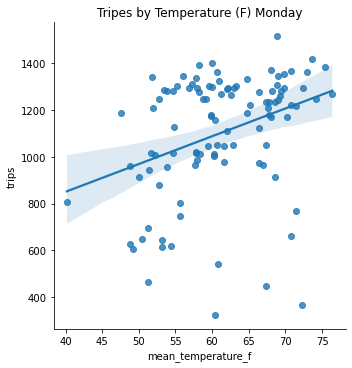

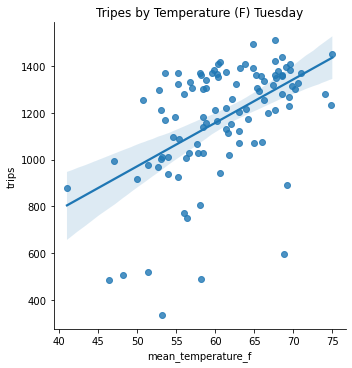

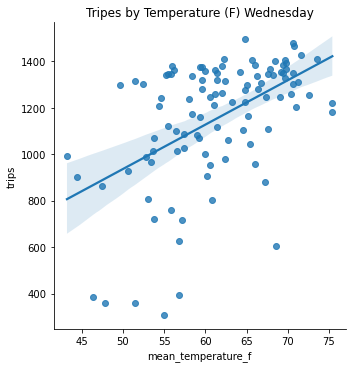

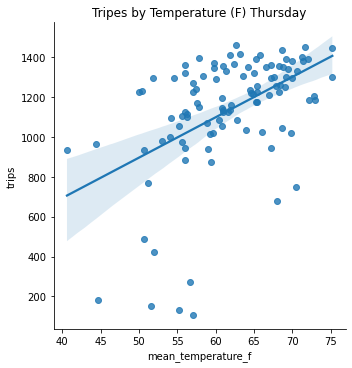

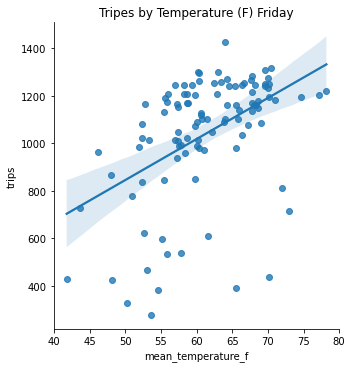

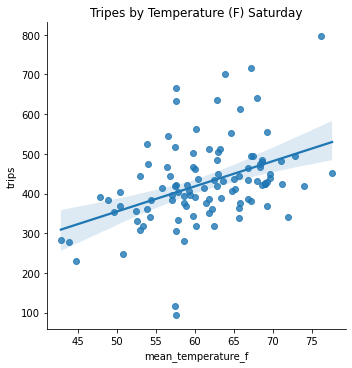

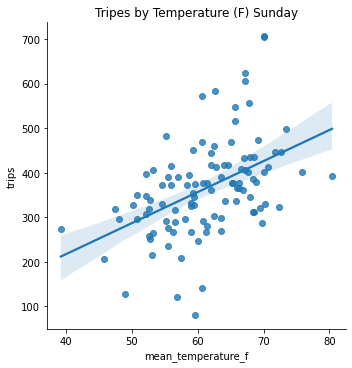

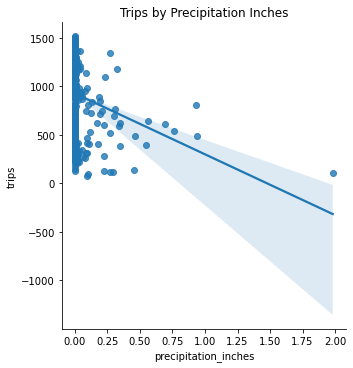

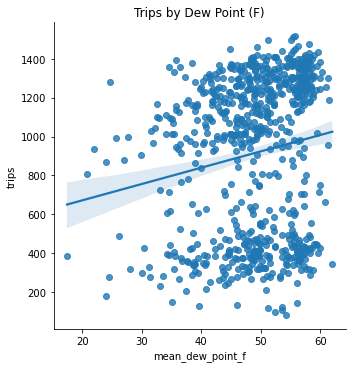

In [72]:
# Get correlation info
factors = ['trips', 'mean_temperature_f', 'mean_dew_point_f','mean_humidity', 'mean_sea_level_pressure_inches', 
           'mean_visibility_miles', 'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover', 
           'wind_dir_degrees']
cor = weather_by_date[factors].corr()
cor = round(cor, 2)
sns.heatmap(cor, annot=True)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot correlation graphs
sns.lmplot(x="mean_temperature_f", y="trips", data=weather_by_date).set(title="Trips by Temperature (F) Total")

for i in range(7):
    sns.lmplot(x="mean_temperature_f", y="trips", data=weather_by_date.loc[(weather_by_date["day"] == i)]).set(title="Tripes by Temperature (F) " + days[i])

sns.lmplot(x="precipitation_inches", y="trips", data=weather_by_date).set(title="Trips by Precipitation Inches")
sns.lmplot(x="mean_dew_point_f", y="trips", data=weather_by_date).set(title="Trips by Dew Point (F)")

From the heatmap of the correlation matrix, we can see that temperature, precipitation, and dew point correlate the most with number of trips, with temperature being the strongest. The scatterplots also show that the strength of this connection, as well as the slope, vary by the day of the week. Both precipitation and dew point have unique graphs, with most precipitation being 0 and the combined temperature plot and the plot for dew point being largely divided into two clusters.

For more information on the difference by day, we can make a violin plot of how many trips occur on day of week. 

[Text(0.5, 1.0, 'Trips by Day of Week')]

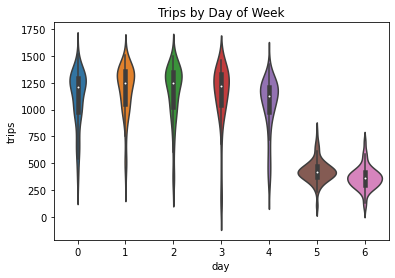

In [30]:
# Violin plots by day
sns.violinplot(data=weather_by_date, x="day", y="trips").set(title="Trips by Day of Week")

We can see that fewer trips occur on the weeeknds, while the weekdays remain reletively the same. This might explain the odd temperature and dew point graph. Lets plot this to check.

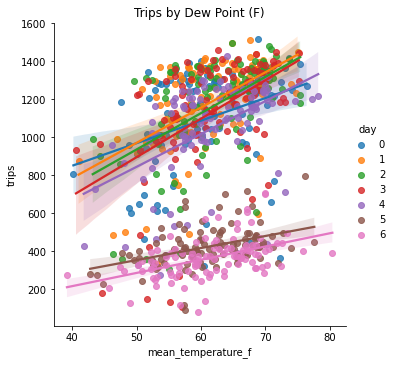

In [74]:
sns.lmplot(x="mean_temperature_f", y="trips", data=weather_by_date, hue="day").set(title="Trips by Dew Point (F)")

As we can see, this indeed appears to be the reason why there are two clusters. Nearly all of the weekend days tend to stay near the bottom, and are also less influenced by the temperature.

From here, we can merge the trip and weather data to provide the weather info for each seperate trip.

In [45]:
# clean data
mldf = pd.merge(trip, weather, left_on=['date','zip_code'], right_on = ['date','zip_code'])
mldf["day"] = pd.to_datetime(mldf["start_date"]).dt.dayofweek
mldf = mldf.drop("max_gust_speed_mph", axis=1)
mldf = mldf.dropna()

mldf.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,day
0,4275,883,2013-08-29 11:43:00,Mechanics Plaza (Market at Battery),75,2013-08-29 11:57:00,South Van Ness at Market,66,626,Subscriber,...,10.0,10.0,10.0,23.0,11.0,0.0,4.0,,286.0,3
1,4290,309,2013-08-29 11:58:00,Powell Street BART,39,2013-08-29 12:03:00,Market at 10th,67,496,Customer,...,10.0,10.0,10.0,23.0,11.0,0.0,4.0,,286.0,3
2,4319,899,2013-08-29 12:10:00,South Van Ness at Market,66,2013-08-29 12:25:00,Beale at Market,56,546,Subscriber,...,10.0,10.0,10.0,23.0,11.0,0.0,4.0,,286.0,3
3,4442,474,2013-08-29 12:56:00,Washington at Kearney,46,2013-08-29 13:04:00,Market at Sansome,77,607,Subscriber,...,10.0,10.0,10.0,23.0,11.0,0.0,4.0,,286.0,3
4,4454,340,2013-08-29 13:05:00,Market at Sansome,77,2013-08-29 13:10:00,Washington at Kearney,46,590,Subscriber,...,10.0,10.0,10.0,23.0,11.0,0.0,4.0,,286.0,3


We can create a correlation matrix to see which variables tend to occcur together. This can give us better insight into what to look into in a visual manner.

<AxesSubplot:>

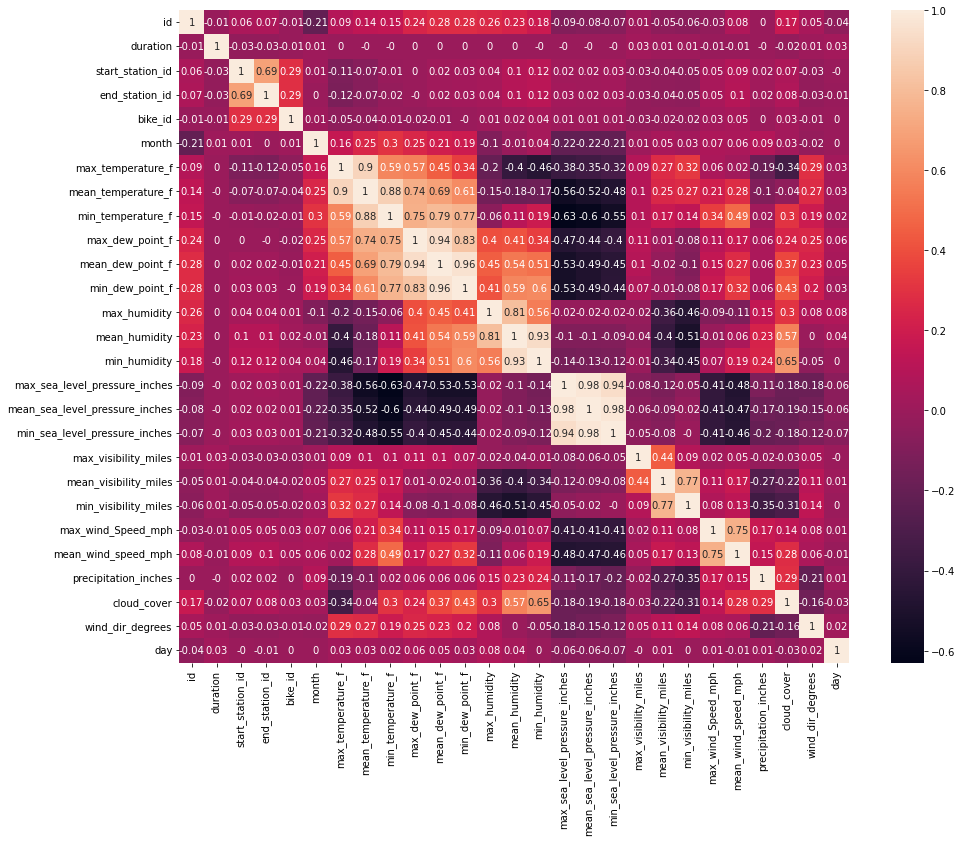

In [46]:
# get only numeric columns
numeric_mldf = mldf.select_dtypes(include=np.number)

plt.figure(figsize=(15, 12))
cor = mldf.corr()
cor = round(cor, 2)
sns.heatmap(cor, annot=True)

As you can see, some of the weather patterns tend to correlate, but many of the values we're interested in, like duration, have almost no correlation with weather. 

## Data Analysis and Hypothesis Testing

## Hypothesis Testing

We saw earlier there seems to be some relationship with mean temperature and the number of trips. We can perform tests to determine if the two variables are correlated.

Our null hypothesis is that there is no relationship between mean temperature and number of trips. The alternative hypothesis is that there is a relationship between mean temperature and number of trips.

The first step before selecting a hypothesis test to use is to determine the distribution of our variables are normal.

<AxesSubplot:>

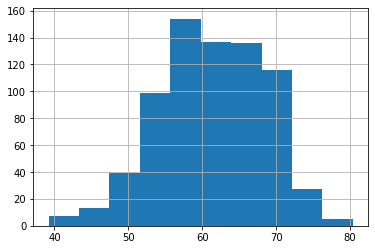

In [31]:
weather_by_date['mean_temperature_f'].hist()

<AxesSubplot:>

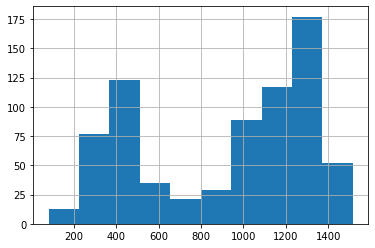

In [32]:
weather_by_date['trips'].hist()

From the two histograms above, it is clear that the number of trips is not normal and appears to be bimodal. Thus this means we need to use a non-parameteric test. One such test is Spearman rank correlation coefficient test which can be used to measure the significance of association between two variables where the 2 variables are not required to be normal. From this test, we can obtain a p-value, which informs us about the significance of the correlation between the 2 variables.


In [33]:
x = np.array(weather_by_date['mean_temperature_f'])
y = np.array(weather_by_date['trips'])

stat, p = st.spearmanr(x, y)

print("p-value: " + str(p))

p-value: 5.864017930805387e-17


From the p-value above, since its value is less than 0.05, we can say that it is statistically significant and that we are able to reject the null hypothesis that stated there is no correlation between the two variables.

## Predicting Subscriber Status from  with Machine Learning

In this section our goal is to use machine learning to help us with predicitions. We chose to tackle a classification problem, using the ride data to identify whether a rider is a subscriber or not.
For the model, we started with thinking about a Linear SVM classifier, which is good for large datasets. Since the dataset of rides is >600k, it works well with this algorithm.  
Scikit Learn's SGDClassifier is able to implement this classifier as well as other linear classifiers, and we are able to test between these to find the most effective.  
Another option would be to use Linear SVC, which is implemented differently. However, it is better to use Linear SVM for larger datasets.

In [65]:
# Set up input values x and y
x = numeric_mldf
y = mldf["subscription_type"]
# Divide into test and train sets
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.15)

This manually goes through different options to find the best ones. This allows us to narrow down the hyperparemeters to give to the grid search below, for better efficiency.

In [66]:
# Used to narrow down the options for hyperparemter optmization (below) for time purposes 

# Iteration count
n_iters = [5, 10, 20, 50, 100]
scores = []
for n_iter in n_iters:
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=n_iter)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print(scores)
print("Highest score: " + str(max(scores)) + " Iter: " + str(n_iters[scores.index(max(scores))]))

# Loss function
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    clf = SGDClassifier(loss=loss, penalty="l2", max_iter=1000)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print(scores)
print("Highest score: " + str(max(scores)) + " Function: " + str(losses[scores.index(max(scores))]))

# Alpha value
alphas = [0.0001, 0.001, 0.01, 0.1]
scores = []
for alpha in alphas:
    clf = SGDClassifier(loss="hinge", penalty="l2", alpha=alpha)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print(scores)
print("Highest score: " + str(max(scores)) + " Alpha: " + str(alphas[scores.index(max(scores))]))

# Penalty
penalties = ["l2", "l1", "elasticnet", "none"]
scores = []
for penalty in penalties:
    clf = SGDClassifier(loss="hinge", penalty=penalty, alpha=alpha)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print(scores)
print("Highest score: " + str(max(scores)) + " Penalty: " + str(penalties[scores.index(max(scores))]))

/Users/Licykk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Licykk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Licykk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Licykk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/L

[0.9621696586794052, 0.9623237537560675, 0.9597811849911395, 0.960012327606133, 0.9617073734494183]
Highest score: 0.9623237537560675 Iter: 10
[0.9616303259110871, 0.9620155636027429, 0.9612450882194314, 0.9624008012943986, 0.9566992834578936]
Highest score: 0.9624008012943986 Function: perceptron
[0.954927190076277, 0.9624008012943986, 0.9624778488327298, 0.9613991832960936]
Highest score: 0.9624778488327298 Alpha: 0.01


/Users/Licykk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[0.9521534786963557, 0.9470683411664997, 0.9442175822482471, 0.9505354803914015]
Highest score: 0.9521534786963557 Penalty: l2


The results have a bit of variation, with the results of one run being max_iter: 10, loss: perceptron, alpha: 0.01, and penalty: l2. Looking at all the scores helps us to choose the best performing ones for the grid search.

We can run a grid search using common parameters to the SGD Classifier. This will give us the optimal parameters, which we can use to create a model below.

In [ ]:
# Hyperparemeter optimization
params = {
    "loss" : ["hinge", "modified_huber", "perceptron"],
    "alpha" : [0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10)

grid.fit(X_train, y_train)

print(grid.best_params_) 

The result of the grid search gives us:
{'alpha': 0.1, 'loss': 'modified_huber', 'penalty': 'l2'}
These values can be used for the SGD Classifier below.

In [55]:
clf = SGDClassifier(loss="modified_huber", penalty="l2", alpha=0.1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred)) 

Accuracy: 0.9603

              precision    recall  f1-score   support

    Customer       0.59      0.07      0.12       526
  Subscriber       0.96      1.00      0.98     12453

    accuracy                           0.96     12979
   macro avg       0.78      0.53      0.55     12979
weighted avg       0.95      0.96      0.94     12979



The overall accuracy of the model was around 96.03%. This accuracy was higher for identifying subscribers than it was for customers, likely due to there being significantly more subscribers, as mentioend above in Data Exploration.

In [57]:
# Cross validation
scores = cross_val_score(clf, x, y, cv=10)

# report performance
print("%0.2f accuracy with a standard deviation (standard error) of %0.2f" % (scores.mean(), scores.std()))

0.84 accuracy with a standard deviation (standard error) of 0.29


Using 10-fold cross validation, the model performs with an accuracy of 0.84, with a standard deviation 0.29.

## Conclusion

